# HPC Coursework 2

# Part 1: Solving a wave problem with sparse matrices
Compute the solution to the following (time-harmonic) wave problem:

$$\frac{d^2u}{dx^2}+k^2u=0$$
$u=0$ if $x=0$ and $u=1$ if $x=1$ for $k=\frac{29\pi}{2}$.

By using method of differences we can approximately solve this. To compute we use:

$$\frac{d^2u}{dx^2}\approx\frac{u_{i-1}-2u_i+u_{i+1}}{h^2}$$

where $h=\frac{1}{N}$

We can rewrite the problem as $$ (2 - h^2k^2)u_i - u_{i-1} - u_{i+1} = 0 $$

This can be phrased as the matrix vector problem $\textbf{Au} = \textbf{f} $. $\textbf{u}$ is an unknown vector to compute. Vectors $\textbf{f}$ and $\textbf{u}$ are described by:

$$
\begin{align*}
\left[\mathbf{u}\right]_i &= u_i,\\
\left[\mathbf{f}\right]_i &= \begin{cases}
1&\text{if }i=N,\\
0&\text{otherwise}.
\end{cases}
\end{align*}
$$
The rows of $\mathrm{A}$ are given by

$$
\left[\mathrm{A}\right]_{i,j} =
\begin{cases}
1&\text{if }i=j,\\
0&\text{otherwise},
\end{cases}
$$
if $i=0$ or $i=N$; and

$$
\left[\mathrm{A}\right]_{i, j} =
\begin{cases}
2-h^2k^2&\text{if }j=i,\\
-1&\text{if }j=i+1,\\
-1&\text{if }j=i-1.\\
0&\text{otherwise},
\end{cases}
$$

In [3]:
import numpy as np
import numba
from numba import cuda, jit, njit
from scipy.sparse import coo_matrix,csr_matrix, linalg
from timeit import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def makeAF(N):
  '''
  Returns the matrices A and f and defined in the equations above
  This is a slower version just to ensure the function is returning the correct matrix

  Inputs
  - N - size of the matrices A and f

  Outputs
  - A - a tridiagonal matrix with the main data in the central diagonal
  and -1 in the offset diagonal elements

  - f - a vector where the last element is 1
  '''
  h=1/N
  k=29*np.pi/2
  realsize = N+1

  # Initialise arrays with zeros
  A = np.zeros((realsize, realsize))
  f=np.zeros(realsize)

# Set last f element to 1
  f[-1]=1

  # Generating the central diagonal for A
  diag = np.ones(N-1)*(2-h**2*k**2)
  diag = np.append(1, diag)
  diag = np.append(diag, 1)

# Setting up the offset diagonals with -1s
  offsetdiag = np.ones(N-1)*-1
  upperdiag = np.append(0,offsetdiag)
  lowerdiag = np.append(offsetdiag, 0)

# Summing eveything together
  A += np.diag(diag)
  A += np.diag(upperdiag, 1)
  A += np.diag(lowerdiag, -1)
  return A, f

print(makeAF(4)[0])

[[   1.            0.            0.            0.            0.        ]
 [  -1.         -127.69277033   -1.            0.            0.        ]
 [   0.           -1.         -127.69277033   -1.            0.        ]
 [   0.            0.           -1.         -127.69277033   -1.        ]
 [   0.            0.            0.            0.            1.        ]]


In [ ]:
def sparseAFcoocsr(N, format='CSR'):
  '''
  Returns the matrices A and f and defined in the equations above
  This is a faster version and uses list comprehension to speed things up

  Inputs
  - N - size of the matrices A and f

  Outputs
  - A - a sparse tridiagonal matrix with the main data in the central diagonal
  and -1 in the offset diagonal elements
  - f - a sparse vector where the last element is 1
  '''
  h=1/N
  k=29*np.pi/2

  diag = np.ones(N - 1) * (2 - h**2 * k**2)
  offdiag = -1 * np.ones(N - 1)

  if format == 'COO':
    #print('COO')
    sparsemat = coo_matrix
  else:
    #print('CSR')
    sparsemat = csr_matrix

  startind = np.concatenate([[0], np.arange(1, N+1)])

  data = np.concatenate(([1], diag, [1], offdiag, offdiag))
  row_indices = np.concatenate((startind, np.arange(1, N), np.arange(1, N)))
  col_indices = np.concatenate((startind, np.arange(0, N -1), np.arange(2, N+1)))

  A = sparsemat((data, (row_indices, col_indices)), shape=(N + 1, N + 1))
  f = sparsemat(([1], ([N], [0])), shape=(N + 1, 1))
  return A, f

print((sparseAFcoocsr(4, 'CSR')[0]).toarray())

[[   1.            0.            0.            0.            0.        ]
 [  -1.         -127.69277033   -1.            0.            0.        ]
 [   0.           -1.         -127.69277033   -1.            0.        ]
 [   0.            0.           -1.         -127.69277033   -1.        ]
 [   0.            0.            0.            0.            1.        ]]


In [ ]:
testrange = np.arange(4,101)

def matrix_test(func1, func2):
    '''Testing the new matrix product function by comparing against @/np.matmul'''
    for i in testrange:
        assert np.isclose(func1(i)[0], func2(i)[0].toarray()).all()
    print('New function works!')

matrix_test(makeAF, sparseAFcoocsr)

New function works!


## Testing COO vs CSR
Here we check to see whether COO or CSR is more appropriate/faster in our scenario by timing the difference in computation time for `linalg.spsolve`. I don't expect there to be much difference because the CSR implentation works better for matrices that are much more sparse than tridiagonal matrices.

In [ ]:
cootimes = []
csrtimes = []

arrsize = np.arange(100000,1600000,200000)

# Looping through solving the linear algebra problem for large matrices
for i in tqdm(arrsize):
  csrt = timeit(lambda:linalg.spsolve(*sparseAFcoocsr(i)), number=10)
  coot = timeit(lambda:linalg.spsolve(*sparseAFcoocsr(i, 'COO')), number=10)
  csrtimes.append(csrt)
  cootimes.append(coot)

  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\jaydi\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


In [ ]:
coomaket = []
csrmaket = []

# Looping through the time taken to make the large matrices
for i in arrsize:
  csrt = timeit(lambda:sparseAFcoocsr(i), number=10)
  coot = timeit(lambda:sparseAFcoocsr(i, 'COO'), number=10)
  csrmaket.append(csrt)
  coomaket.append(coot)

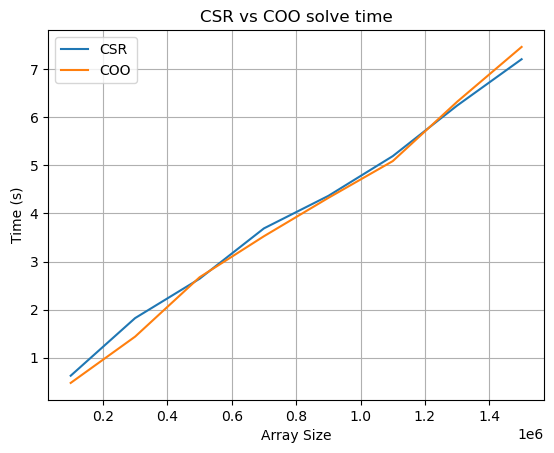

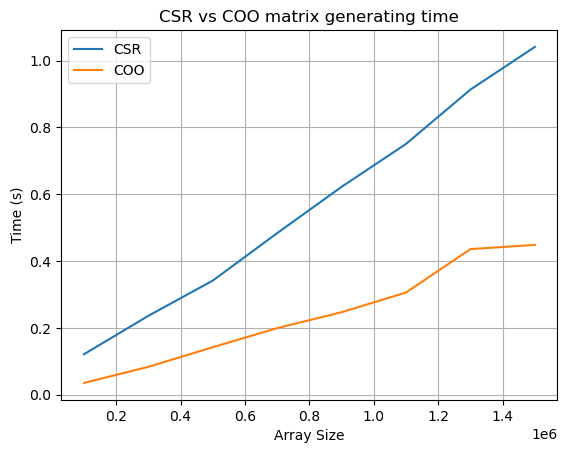

In [ ]:
plt.plot(arrsize, csrtimes, label='CSR')
plt.plot(arrsize, cootimes, label='COO')
plt.legend()
plt.xlabel('Array Size')
plt.ylabel('Time (s)')
plt.title('CSR vs COO solve time')
plt.grid()
plt.show()

plt.plot(arrsize, csrmaket, label='CSR')
plt.plot(arrsize, coomaket, label='COO')
plt.legend()
plt.title('CSR vs COO matrix generating time')
plt.xlabel('Array Size')
plt.ylabel('Time (s)')
plt.grid()

### Discussion
We can see that there is little to no difference in the processing time between CSR and COO sparse matrix style, even though the time to make a COO matrix is consistently much less. This is because `linalg.spsolver` works better with the CSR format and even gives a warning: `SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format')`.

I will use CSR because it has a better implementation in Python.

In [ ]:
def sparseAF(N, format='CSR'):
  '''
  Returns the matrices A and f as defined in the equations above
  This should be a faster version and uses list comprehension to speed things up
  and removes the COO/CSR matrix boolean part to speed up as well

  Inputs
  - N - size of the matrices A and f

  Outputs
  - A - a sparse tridiagonal matrix with the main data in the central diagonal
  and -1 in the offset diagonal elements

  - f - a sparse vector where the last element is 1
  '''
  h=1/N
  k=29*np.pi/2

  diag = np.ones(N - 1) * (2 - h**2 * k**2)
  offdiag = -1 * np.ones(N - 1)


  startind = np.concatenate([[0], np.arange(1, N+1)])

  data = np.concatenate(([1], diag, [1], offdiag, offdiag))

  # row_indices and col_indices contain the necessary figures to map the data to the correct places
  row_indices = np.concatenate((startind, np.arange(1, N), np.arange(1, N)))
  col_indices = np.concatenate((startind, np.arange(0, N -1), np.arange(2, N+1)))

  A = csr_matrix((data, (row_indices, col_indices)), shape=(N + 1, N + 1))
  f = csr_matrix(([1], ([N], [0])), shape=(N + 1, 1))
  return A, f

## Plotting the solution
Here we plot the solution to $u$

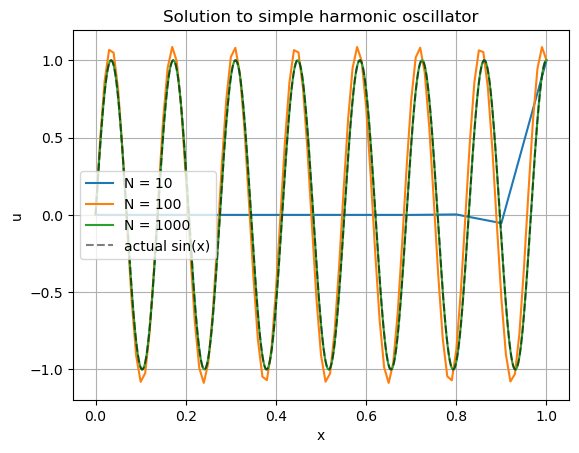

In [ ]:
# Looping through size of N generating values of u by solving the equations
for N in [10,100,1000]:
    plt.plot(np.linspace(0,1,N+1),
             linalg.spsolve(*sparseAF(N)),label=f'N = {N}')

# Generating exact solution sin(29pi/2 x)
x=np.linspace(0,1,10000)
y=np.sin(29*np.pi/2*x)

plt.plot(x, y, ls='--', alpha=0.5, c='k', label='actual sin(x)')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Solution to simple harmonic oscillator')
plt.legend(loc='best')
plt.grid()

### Discussion
As expected, we can see that the N=1000 solution is the closest to $y=sin(x)$ as it contains enough iterative steps to get to a closer answer. N=100 is starting to get there but doesn't quite stay between the $[-1,1]$ range typical of the $sin$ function.

## Compute the error
The exact solution is known:$$u_{exact}(x)=sin(kx)$$

A measure of the error in the solution can be found by computing $$max_i|u_i−u_{exact}(x_i)|$$

Compute this error for a range of values for N
 of your choice, for the method you wrote above. On axes that both use log scales, plot N
 against the error in your solution. You should pick a range of values for N
 so that this plot will give you useful information about the methods.

In [ ]:
error = []
N = np.arange(1000,5.01e6, 50000, dtype=int)

for i in tqdm(N):
  x=np.linspace(0,1,int(i)+1)
  uexact = np.sin(29*np.pi/2*x)
  ui = linalg.spsolve(*sparseAF(int(i)))
  error.append(np.max(np.abs(ui - uexact)))

100%|██████████| 101/101 [02:15<00:00,  1.34s/it]


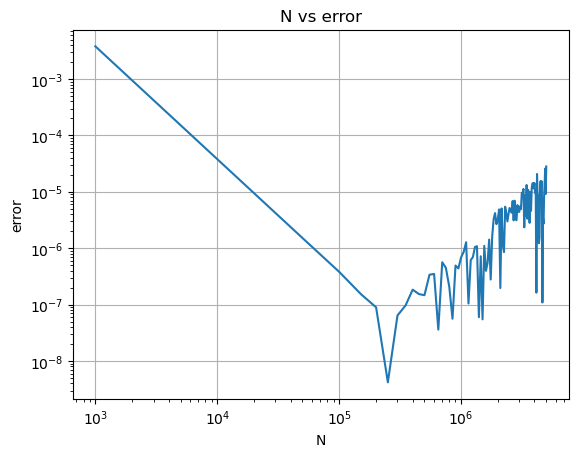

In [ ]:
plt.plot(N, error)
plt.title('N vs error')
plt.xlabel('N')
plt.ylabel('error')
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [ ]:
time = []

for i in tqdm(N):
  t = timeit(lambda:linalg.spsolve(*sparseAF(int(i))), number=1)
  time.append(t)

100%|██████████| 101/101 [02:06<00:00,  1.25s/it]


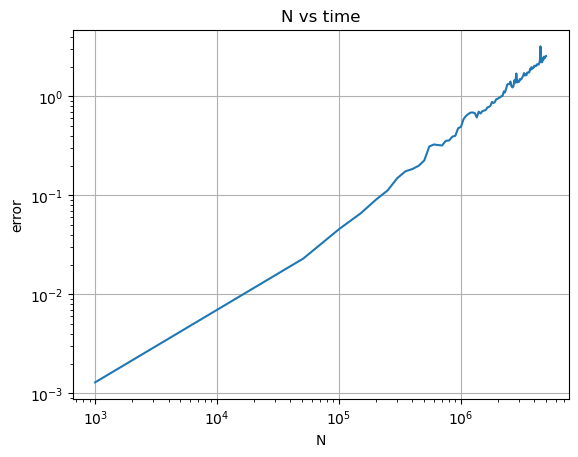

In [ ]:
plt.plot(N, time)
plt.title('N vs time')
plt.xlabel('N')
plt.ylabel('error')
plt.xscale('log')
plt.yscale('log')
plt.grid()

### Discussion

We can see from the error chart that the error approaches a minimum at $N\approx 1 \times 10^5$ where it almost reaches a minimum error of $10^{-8}$. The error decreases as $N$ increases, up until the minimum after which the error begins to increase with $N$.

Initially the error decreases because increasing $N$ leads to finer discretisation, giving a more accurate solution. However numerical errors start to accumulate due to limited floating-point precision.

The logarithm of computation time vs $logN$ appears rougly linear. There is some noisy points at higher values maybe due to the Colab environment limiting resources.

## Computing for errors below $10^{-8}$
By looking at your plots, pick a value of $N$ that you would expect to give error of $10^{-8}$ or less and predict how long the computation will take.

### Prediction
I predict errors below $10^-8$ to occur between $10^5<N<10^6$, with a computation time of $t\approx 10^{-1}$.

By looking at the chart we can see it reaches a local minimum at $N\approx 10^{5}$ and the corresponding value on the time chart is $t\approx 10^{-1}$. By focusing on this smaller range we will be able to see more accurately where the minimum is.

In [ ]:
finererror = []
finertime = []

# We loop through a smaller range here based on our prediction
N = np.arange(1e5,1e6,1e4, dtype=int)

for i in tqdm(N):

  # Actual sin values
  x=np.linspace(0,1,int(i)+1)
  uexact = np.sin(29*np.pi/2*x)

  # Solving linear equations
  ui = linalg.spsolve(*sparseAF(int(i)))

  finererror.append(np.max(np.abs(ui - uexact)))

  ftime = timeit(lambda:linalg.spsolve(*sparseAF(int(i))), number=1)
  finertime.append(ftime)

100%|██████████| 90/90 [00:46<00:00,  1.95it/s]


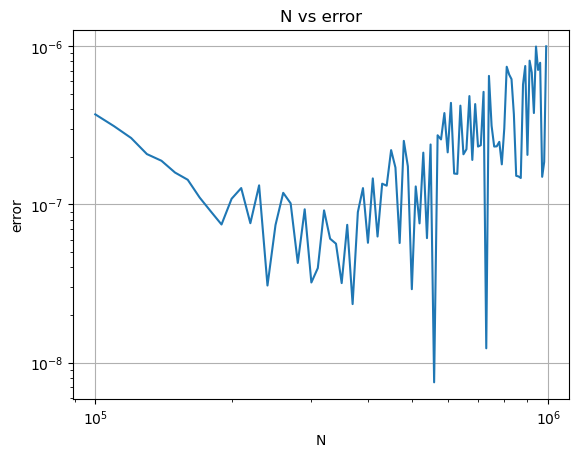

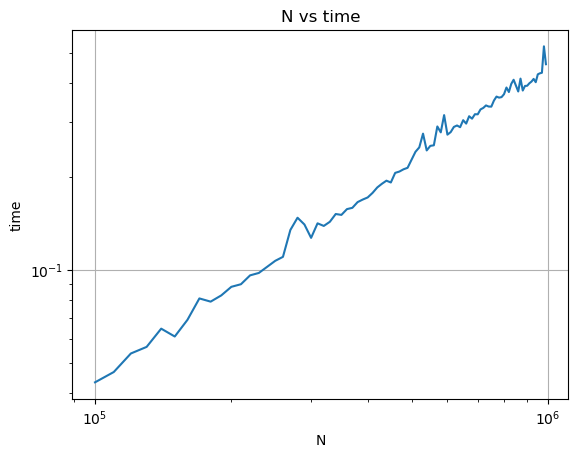

In [ ]:
plt.plot(N, finererror)
plt.title('N vs error')
plt.xlabel('N')
plt.ylabel('error')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

plt.plot(N, finertime)
plt.title('N vs time')
plt.xlabel('N')
plt.ylabel('time')
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [ ]:
print(f'Lowest error: {np.min(finererror):.2e} at N = {N[np.argmin(finererror)]}: taking {finertime[np.argmin(finererror)]:.2e}s')

Lowest error: 7.54e-09 at N = 560000: taking 2.52e-01s


### Discussion
Close to my prediction, the lowest error ($7.54\times 10^{-9}$) occurs at $N=56000$, with the time taken ($2.86\times 10^{-1}$ s) at the predicted order of magnitude. The time vs N relationship remains roughly linear in this region and we can also in the error vs N chart some sort of local minimum. I have run this cell a few times to see if the position of the lowest error changes, but it still occurs at the spike between $55000-57000$. The value of $N$ and time required is within the capabilities of my relatively cheap CPU.

# Part 2 - Solving the heat equation
## GPU acceleration
We want to solve the heat equation for a rod that starts at 0 and is heated to 10 at both ends.

$$
\begin{align*}
\frac{du}{dt} &= \frac{1}{1000}\frac{d^2u}{dx^2}&&\text{for }x\in(0,1),\\
u(x, 0) &= 0,&&\text{if }x\not=0\text{ and }x\not=1\\
u(0,t) &= 10,\\
u(1,t) &= 10.
\end{align*}
$$

It can be approximately solved by taking evenly spaced values
$x_0=0, x_1, x_2, ..., x_N=1$ and a set of evenly spaced times
$t_0=0,t_1=h, t_2=2h, t_3=3h, ...$, where $h=1/N$.

We write $u^{(j)}_{i}$ for the approximate value of $u$ at point $x_i$ and time $t_j$ (i.e. $u^{(j)}_{i}\approx u(x_i, t_j)$).

Approximating both derivatives we can rewrite the heat equation as

$$
\begin{align*}
u^{(j + 1)}_i&=u^{(j)}_i + \frac{u^{(j)}_{i-1}-2u^{(j)}_i+u^{(j)}_{i+1}}{1000h},\\
u^{(0)}_i &= 0,\\
u^{(j)}_{0}&=10,\\
u^{(j)}_{N}&=10.
\end{align*}
$$

The problem can be solved by:

$$
u^{(j+1)}_i =
\begin{cases}
10 &\text{if }i=0\text{ or }i=N,\\
\displaystyle u^{(j)}_i + \frac{u^{(j)}_{i-1}-2u^{(j)}_i+u^{(j)}_{i+1}}{1000h} &\text{otherwise}.
\end{cases}
$$

In [91]:
def makeU(N):
  '''
  Returns the matrix u as defined in the equations above
  the matrix u is a matrix with the temperature along the bar where each row is
  the temperature along the bar at different time steps up
  until t=1000s

  Inputs
  - N - number of steps between x=0 and x=1

  Outputs

  - u - a matrix with the values of u at each time step
        where each row is the temperature along the bar at different time steps
  '''
  h = 1/N

  # Stop calculating bar temp at 1000s
  t_end = 500
  tpoints = np.arange(0,(t_end*N))

  u = np.zeros((len(tpoints)+1, N+1))
  # Sets boundary conditions
  u[:,0]=u[:,-1]=10

  n = np.arange(1,N)

  for j in tpoints:
    for i in n:
      u[j+1][i] = u[j][i] + (u[j][i-1]-2*u[j][i]+u[j][i+1])/(1000*h)
  return u

In [92]:
N = 250
temp = makeU(N)

### Discussion
High $N$ values will cause the second term in $u_{i}^{(j+1)}$ to dominate. It also massively increases the computation time, so we set $N=250$.

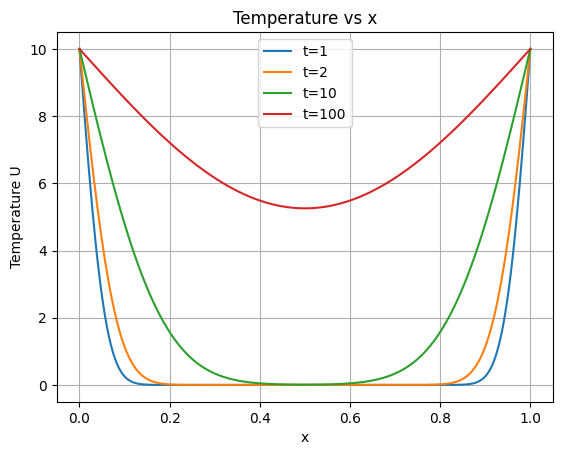

In [93]:
x=np.linspace(0, 1, N+1)

# Plotting the temperature at 1s, 2s, 10s and 100s
plt.plot(x, temp[1*N], label='t=1')
plt.plot(x, temp[2*N], label='t=2')
plt.plot(x, temp[10*N], label='t=10')
plt.plot(x, temp[100*N], label='t=100')
plt.grid()
plt.xlabel('x')
plt.ylabel('Temperature U')
plt.title('Temperature vs x')
plt.legend(loc='best');

## GPU acceleration
Here we are doing the same calculation but now use GPU parallelisation to speed up everything

In [153]:
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-174ee971-96e5-ae5f-4d93-a14a53d39c5e
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [154]:
@cuda.jit
def ucuda(ucurrent, unew):
  """
  Solves heat equation for the rod using GPU optimisation
  We parallelise by only copying the row needed for calculation
  The length of ucurrent is the same as N

  Inputs:
  ucurrent - Current temperature array
  unew - New temperature array to be calculated
  """


  i = cuda.grid(1)

  # Getting the right row length
  size = len(ucurrent) - 1

  # u calculatioin
  if 0 < i < ucurrent.size - 1:
    unew[i] = ucurrent[i] + ((ucurrent[i+1] - 2*ucurrent[i]
                              + ucurrent[i-1])/(1000))*size
  else:
    pass

In [155]:
N = 250

# Time end at 500s
time_limit = 500

# Create a 2D array to store temperatures
utimecuda = np.zeros((N * time_limit + 1, N + 1))

# Set boundary conditions
utimecuda[:, 0] = utimecuda[0:, -1] = 10

# Copy initial conditions to GPU
u_gpu_current = cuda.to_device(utimecuda[0])
u_gpu_new = cuda.to_device(u_gpu_current)

# CUDA grid configuration
threads_per_block = 256   # Some multiple of 32 close to N
blocks_per_grid = ((N * time_limit) + threads_per_block - 1) // threads_per_block

# Calculation loop
for i in range(N * time_limit):

  ucuda[blocks_per_grid, threads_per_block](u_gpu_current, u_gpu_new)

  # Copy the new time step to the host 2D array
  utimecuda[i+1] = u_gpu_new.copy_to_host()

  # Swap gpu arrays for the next iteration
  u_gpu_current =u_gpu_new

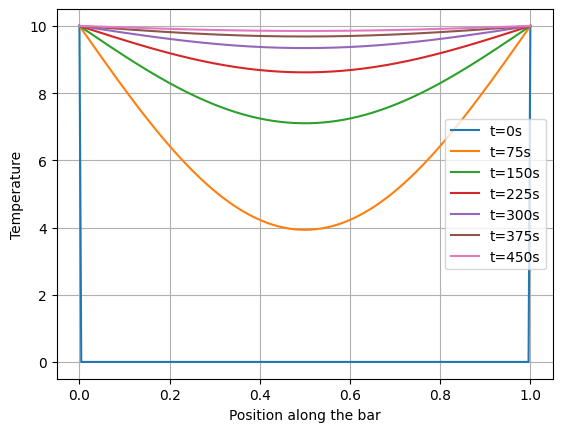

In [156]:
# Plot the temperature
for i in np.arange(0, N*time_limit, 75*N):
  plt.plot(np.linspace(0, 1, N + 1), utimecuda[i], label=f't={int(i/N)}s')
plt.xlabel('Position along the bar')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='best');

In [157]:
# Testing the arrays are identical
assert np.isclose(temp, utimecuda).all()

### Discussion
This CUDA implementation is much faster.

To calculate the necesaary threads and block, we need threads to be some mulitple of 32. I initially set it to 32 and got an underutilisation warning so upped it to 256 close to $N$. The block calculation determines how many blocks are required to cover all N points with the specified number of threads per block. $$\frac {\text{no. of elements}}{\text{threads per block}}=\text{blocks per grid}$$

For the main loop, we call `ucuda[blocks_per_grid, threads_per_block](u_gpu_current, u_gpu_new)` to specify we're using CUDA. We update the CPU stored value after every loop and also update the "current" row with the new row values.

In [148]:
# Finding the midpoint temperature

N = 250

# Set end time to 1000s
time_limit = 1000
mid_point = int((N/2))

u = np.zeros((N+1))
u[0] = u[-1] = 10

u_gpu_midc = cuda.to_device(u)
u_gpu_midn = cuda.to_device(u_gpu_midc)

# Set array to store midpoints
u_vals = []

# Calculation loop
for i in range(N * time_limit):
  ucuda[blocks_per_grid, threads_per_block](u_gpu_midc, u_gpu_midn)

  # Copy the new time step to the cpu 2D array
  umid = u_gpu_midn.copy_to_host()
  u_vals.append(umid[mid_point])

  # Swap gpu arrays for the next iteration
  u_gpu_current = u_gpu_new

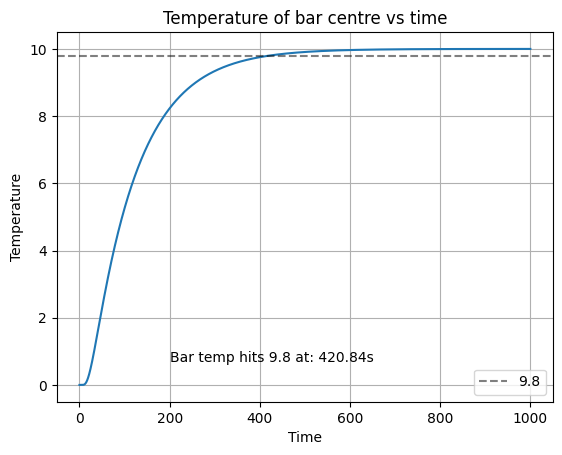

In [150]:
plt.plot(np.linspace(0, 1000, N*time_limit), u_vals)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature of bar centre vs time')
plt.axhline(y=9.8, c='k', ls='--', alpha=0.5, label='9.8')
plt.legend()

# Finding where the midpoint first exceeds 9.8
time = np.argmax(np.array(u_vals) > 9.8)
real_time = time/N
plt.text(200, 0.7, f'Bar temp hits 9.8 at: {time/N}s');

### Discussion
By plotting the temperature of the middle of the bar against time and finding where exactly in the array the bar tempreature is above $9.8$, we can see that the middle of the bar reaches a temperature of $9.8$ at $420.84 s$. After $9.8$, the temperature plateaus until it reaches $10$.